In [1]:
# -*- coding: utf-8 -*-
"""
Code to produce figure of Twitter users per country in per-author normalization (mode).
Exports:
- df_geo_recoded_with_norm.csv
- geo_mentions_map_norm.pdf         (fixed bins: 1–10, 11–100, 101–500, 501–1000, 1000+)
- geo_mentions_noncountries_norm.pdf
"""

import os
import re
import unicodedata
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# ── Paths ─────────────────────────────────────────────────────────────────────
BASE_DIR = "/projappl/project_2004147/visions/bertopic_with_zeroshot_v9"
IN_CSV   = os.path.join(BASE_DIR, "df_geo_recoded_anon.csv")
OUT_CSV  = os.path.join(BASE_DIR, "df_geo_recoded_with_norm.csv")
OUT_MAP  = os.path.join(BASE_DIR, "geo_mentions_map_norm.pdf")
OUT_BAR  = os.path.join(BASE_DIR, "geo_mentions_noncountries_norm.pdf")

# ── Load ──────────────────────────────────────────────────────────────────────
df = pd.read_csv(IN_CSV, low_memory=False)

required_cols = {"author_id", "Recoded_countries", "Remaining_non_countries"}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns in {IN_CSV}: {missing}")

# ── Helpers ───────────────────────────────────────────────────────────────────
def _clean_str(x):
    if pd.isna(x): return ""
    s = str(x).strip().strip(' "\'[](){}')
    return s

df["Recoded_countries"] = df["Recoded_countries"].apply(_clean_str)
df["Remaining_non_countries"] = df["Remaining_non_countries"].apply(_clean_str)

def mode_nonempty(series: pd.Series) -> str:
    s = series.astype(str).str.strip()
    s = s[(s != "") & (~s.str.lower().isin({"nan", "n/a"}))]
    if s.empty:
        return ""
    vc = s.value_counts(dropna=True)
    top = vc[vc.eq(vc.max())].index.tolist()
    return sorted(top)[0]

# ── Per-author modes → attach to all rows ─────────────────────────────────────
by_author = df.groupby("author_id", dropna=False).agg(
    Recoded_countries_norm=("Recoded_countries", mode_nonempty),
    Remaining_non_countries_norm=("Remaining_non_countries", mode_nonempty),
).reset_index()

df = df.merge(by_author, on="author_id", how="left")
df.to_csv(OUT_CSV, index=False)
print(f"Saved normalized CSV: {OUT_CSV}")

# ── One vote per author (unbiased counts) ─────────────────────────────────────
authors = by_author.copy()

# ── Load Natural Earth (admin_0) ──────────────────────────────────────────────
world = None
try:
    from geodatasets import get_path
    world_path = get_path("naturalearth.cultural.v10.admin_0_countries")
    gdf = gpd.read_file(world_path)
    name_col = "NAME_EN" if "NAME_EN" in gdf.columns else ("NAME" if "NAME" in gdf.columns else None)
    if name_col is None:
        raise RuntimeError("No NAME/NAME_EN in Natural Earth admin_0_countries.")
    world = gdf[[name_col, "geometry"]].rename(columns={name_col: "name"})
except Exception:
    import cartopy.io.shapereader as shpreader
    shp = shpreader.natural_earth("110m", "cultural", "admin_0_countries")
    gdf = gpd.read_file(shp)
    name_col = "NAME_EN" if "NAME_EN" in gdf.columns else ("NAME" if "NAME" in gdf.columns else None)
    if name_col is None:
        raise RuntimeError("No NAME/NAME_EN in cartopy Natural Earth file.")
    world = gdf[[name_col, "geometry"]].rename(columns={name_col: "name"})

WORLD_NAMES = set(world["name"])
LUT_LOWER_TO_OFFICIAL = {n.lower(): n for n in world["name"]}

ALIASES = {
    "czech republic": "Czechia",
    "ivory coast": "Côte d'Ivoire",
    "cape verde": "Cape Verde",
    "the bahamas": "The Bahamas",
    "bahamas": "The Bahamas",
    "the gambia": "The Gambia",
    "gambia": "The Gambia",
    "turkiye": "Turkey",
    "türkiye": "Turkey",
    "united states": "United States of America",
    "usa": "United States of America",
    "u.s.a.": "United States of America",
    "u.s.": "United States of America",
    "us": "United States of America",
    "uk": "United Kingdom",
    "u.k.": "United Kingdom",
    "russian federation": "Russia",
    "svalbard": "Svalbard and Jan Mayen",
    "faeroe islands": "Faroe Islands",
    "timor leste": "Timor-Leste",
}

def normalize_simple(x: str) -> str:
    if pd.isna(x): return ""
    s = str(x).strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

def to_world_name(country: str) -> str:
    """Map string to official Natural Earth name (strict)."""
    if not isinstance(country, str) or not country.strip():
        return ""
    s = normalize_simple(country)
    if s in WORLD_NAMES:
        return s
    low = s.lower()
    if low in LUT_LOWER_TO_OFFICIAL:
        return LUT_LOWER_TO_OFFICIAL[low]
    if low in ALIASES and ALIASES[low] in WORLD_NAMES:
        return ALIASES[low]
    t = s.title()
    return t if t in WORLD_NAMES else ""

# ── Country & non-country counts from per-author modes ────────────────────────
authors["Recoded_countries_norm_mapped"] = authors["Recoded_countries_norm"].apply(to_world_name)

country_counts = (
    authors["Recoded_countries_norm_mapped"]
    .replace("", np.nan)
    .dropna()
    .value_counts()
    .rename_axis("name")
    .reset_index(name="count")
)

non_df = (
    authors["Remaining_non_countries_norm"]
    .astype(str).str.strip()
    .replace({"": np.nan, "nan": np.nan, "N/A": np.nan, "n/a": np.nan})
    .dropna()
    .value_counts()
    .rename_axis("value")
    .reset_index(name="count")
)

# ── Merge counts to world ─────────────────────────────────────────────────────
world_map = world.merge(country_counts, on="name", how="left")

# ── Plot style ────────────────────────────────────────────────────────────────
plt.rcParams.update({
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
    "font.size": 11, "savefig.dpi": 600,
})

# ── Fixed bins for map: 1–10, 11–100, 101–500, 501–1000, 1000+ ───────────────
labels = ["1–10", "11–100", "101–500", "501–1000", "1000+"]
# boundaries are [1,11,101,501,1001, upper_limit]
if country_counts.empty:
    vmax = 0
else:
    vmax = int(country_counts["count"].max())
upper = max(vmax + 1, 1002)  # ensure last edge above 1000
edges = [1, 11, 101, 501, 1001, upper]

cmap = ListedColormap(plt.cm.Blues(np.linspace(0.35, 0.95, len(labels))))
norm = BoundaryNorm(edges, ncolors=cmap.N, clip=False)

# ========== FIGURE 1: Choropleth (no title) ==================================
fig1, ax_map = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax_map, linewidth=0.3, color="#aaaaaa")

positive = world_map["count"].fillna(0) > 0
if positive.any():
    world_map.loc[positive].plot(
        ax=ax_map, column="count", cmap=cmap, norm=norm,
        linewidth=0.1, edgecolor="white"
    )

# Categorical legend (patches)
handles = [Patch(facecolor=cmap(i), edgecolor="none", label=lab) for i, lab in enumerate(labels)]
leg = ax_map.legend(handles=handles, title=None, loc="lower left", frameon=False)

ax_map.axis("off")
fig1.tight_layout()
fig1.savefig(OUT_MAP, dpi=600, bbox_inches="tight")
plt.close(fig1)

# ========== FIGURE 2: Non-country bar (no title) ==============================
fig2, ax_bar = plt.subplots(figsize=(9, 10))

if not non_df.empty:
    TOP_N = 25
    top_non = non_df.head(TOP_N)
    ax_bar.barh(top_non["value"][::-1], top_non["count"][::-1])
    ax_bar.set_xlabel("Authors"); ax_bar.set_ylabel("Value")
    ax_bar.grid(axis="x", linestyle=":", linewidth=0.5, alpha=0.6)
    for s in ["top", "right"]:
        ax_bar.spines[s].set_visible(False)
else:
    ax_bar.text(0.5, 0.5, "No non-country values found",
                ha="center", va="center", transform=ax_bar.transAxes)
    ax_bar.set_xticks([]); ax_bar.set_yticks([])
    for s in ["top","right","left","bottom"]:
        ax_bar.spines[s].set_visible(False)

fig2.tight_layout()
fig2.savefig(OUT_BAR, dpi=600, bbox_inches="tight")
plt.close(fig2)

print(f"Saved normalized CSV: {OUT_CSV}")
print(f"Saved map:           {OUT_MAP}")
print(f"Saved bar:           {OUT_BAR}")


Saved normalized CSV: /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/df_geo_recoded_with_norm.csv
Saved normalized CSV: /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/df_geo_recoded_with_norm.csv
Saved map:           /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/geo_mentions_map_norm.pdf
Saved bar:           /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/geo_mentions_noncountries_norm.pdf


In [2]:
# -*- coding: utf-8 -*-
"""
The code to create IPBES sub-region maps for relative dominance of meta-categories:
- ND% vs sub-region medians for nine Meta_Category values:
    ND% = 100 * (share - median) / (share + median)
- Draws country polygons coloured by IPBES sub-region (no dissolve).
- LINEAR, PANEL-RELATIVE SCALING:
    For each subplot/category, values are rescaled so that ±100% equals that
    panel's 95th-percentile |ND%|. This equalizes contrast across panels but
    removes cross-panel comparability.

Output:
  ipbes_subregion_meta_pctdiff_maps.pdf (3×3 grid, single colorbar)
"""

import os, io, re, json, hashlib, unicodedata, urllib.request, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path
from matplotlib.patches import PathPatch

warnings.filterwarnings("ignore", category=UserWarning)

# ── Paths ─────────────────────────────────────────────────────────────────────
BASE_DIR = "."
IN_CSV   = os.path.join(BASE_DIR, "df_geo_recoded_with_norm_zeroshot_with_meta2_anon.csv")
OUT_PDF  = os.path.join(BASE_DIR, "ipbes_subregion_meta_pctdiff_maps.pdf")

# IPBES CSV (local or download)
IPBES_CSV_LOCAL = os.path.join(BASE_DIR, "ipbes_regions_subregions_1.1.csv")
IPBES_CSV_URL   = "https://zenodo.org/records/3928281/files/ipbes_regions_subregions_1.1.csv?download=1"

# Natural Earth (GeoJSON) fallback sources (small files)
NAT_EARTH_URLS = [
    "https://raw.githubusercontent.com/geopandas/geopandas/main/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.geojson",
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson",
]

# ── Small helpers ─────────────────────────────────────────────────────────────
def _clean(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    return np.nan if s == "" else s

def normalize_simple(x: str) -> str:
    if pd.isna(x): return ""
    s = str(x).strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

def _norm_key(s: str) -> str:
    if pd.isna(s): return ""
    s = unicodedata.normalize("NFKD", str(s)).lower()
    s = s.replace("–", "-").replace("—", "-").replace("’", "'")
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z0-9]+", " ", s).strip()
    return s

def _normcol(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).lower()
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def _cache_path(url: str) -> str:
    os.makedirs(os.path.join(BASE_DIR, ".ne_cache"), exist_ok=True)
    h = hashlib.sha256(url.encode("utf-8")).hexdigest()[:16]
    ext = ".geojson" if url.lower().endswith(".geojson") else (os.path.splitext(url)[1] or ".dat")
    return os.path.join(BASE_DIR, ".ne_cache", f"ne_cache_{h}{ext}")

def _download(url: str) -> str:
    fp = _cache_path(url)
    if not os.path.exists(fp):
        with urllib.request.urlopen(url) as r, open(fp, "wb") as f:
            f.write(r.read())
    return fp

def _load_geojson_any(urls) -> dict:
    last_err = None
    for url in urls:
        try:
            fp = _download(url)
            with open(fp, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not load any Natural Earth GeoJSON. Last error: {last_err}")

# ── Load inputs ───────────────────────────────────────────────────────────────
if not os.path.exists(IN_CSV):
    raise FileNotFoundError(f"Input file not found at '{IN_CSV}'.")

usecols = ["Recoded_countries_norm", "Remaining_non_countries_norm", "Meta_Category"]
df = pd.read_csv(IN_CSV, usecols=usecols, low_memory=False)
df["Meta_Category"] = df["Meta_Category"].apply(_clean)

# IPBES regions/subregions
def load_ipbes_csv(path_local, url):
    if os.path.exists(path_local):
        return pd.read_csv(path_local)
    with urllib.request.urlopen(url) as resp:
        data = resp.read()
    return pd.read_csv(io.BytesIO(data))

ipbes = load_ipbes_csv(IPBES_CSV_LOCAL, IPBES_CSV_URL)
cols_map = {_normcol(c): c for c in ipbes.columns}
iso_col    = cols_map.get("iso_3166_alpha_3") or cols_map.get("iso3_code") or cols_map.get("iso3")
region_col = cols_map.get("region") or cols_map.get("ipbes_region")
subreg_col = (cols_map.get("sub_region") or cols_map.get("subregion") or
              cols_map.get("sub_regions") or cols_map.get("sub_region_name") or
              cols_map.get("sub_region_label"))
if not all([iso_col, region_col, subreg_col]):
    raise RuntimeError(f"IPBES CSV columns not found. Seen: {list(ipbes.columns)}")

ipbes = ipbes[[iso_col, region_col, subreg_col]].rename(
    columns={iso_col: "iso3", region_col: "ipbes_region", subreg_col: "ipbes_subregion"}
)
ipbes["iso3"] = ipbes["iso3"].astype(str).str.upper().str.strip()
ipbes["ipbes_subregion"] = ipbes["ipbes_subregion"].astype(str).str.strip()

# Canonical keys for subregions
sub_keys = ipbes["ipbes_subregion"].apply(_norm_key)
normkey_to_official_sub = {}
for k, v in zip(sub_keys, ipbes["ipbes_subregion"]):
    normkey_to_official_sub.setdefault(k, v)
VALID_SUBREGIONS = set(normkey_to_official_sub.values())
ISO3_TO_SUBREG = dict(zip(ipbes["iso3"], ipbes["ipbes_subregion"]))

# ── Non-country -> subregion mapping ──────────────────────────────────────────
DROP_ENTITIES_RAW = {
    "global","world","united nations","commonwealth","eu","european union",
    "apac","americas","europe","asia","africa","oceania","europe and africa",
    "latin america","middle east and north africa","mena"
}
DROP_ENTITIES = {_norm_key(x) for x in DROP_ENTITIES_RAW}

_alias = {
    "north africa": "northern africa",
    "west africa": "western africa",
    "central africa": "middle africa",
    "middle africa": "middle africa",
    "east africa": "eastern africa",
    "eastern africa": "eastern africa",
    "southern africa": "southern africa",
    "northern america": "northern america",
    "central america": "central america",
    "caribbean": "caribbean",
    "south america": "south america",
    "eastern europe": "eastern europe",
    "northern europe": "northern europe",
    "southern europe": "southern europe",
    "western europe": "western europe",
    "western asia": "western asia",
    "middle east": "western asia",
    "gulf": "western asia",
    "balkans": "southern europe",
    "nordic countries": "northern europe",
    "nordic": "northern europe",
    "nordics": "northern europe",
    "central asia": "central asia",
    "eastern asia": "eastern asia",
    "south eastern asia": "south eastern asia",
    "southeast asia": "south eastern asia",
    "south east asia": "south eastern asia",
    "southern asia": "southern asia",
    "south asia": "southern asia",
    "oceania": "oceania",
    "australia and new zealand": "australia and new zealand",
    "melanesia": "melanesia",
    "micronesia": "micronesia",
    "polynesia": "polynesia",
}

def map_label_to_official_ipbes_subregion(x: str) -> str:
    key = _norm_key(x)
    if not key: return ""
    if key in normkey_to_official_sub:
        return normkey_to_official_sub[key]
    if key in _alias:
        canon = _alias[key]
        if canon in normkey_to_official_sub:
            return normkey_to_official_sub[canon]
    return ""

def standardise_non_country(name: str) -> str:
    raw = str(name)
    low = normalize_simple(raw).lower().strip()
    if low.startswith("european union"): low = "european union"
    if low in {"europe, africa","africa and europe","europe and africa"}: low = "europe and africa"
    return low

def map_non_country_to_subregion(x: str) -> str:
    low = standardise_non_country(x)
    if not low or _norm_key(low) in DROP_ENTITIES: return ""
    return map_label_to_official_ipbes_subregion(low)

# ── Natural Earth GeoJSON & geometry store ────────────────────────────────────
gj = _load_geojson_any(NAT_EARTH_URLS)
features = gj["features"]

prop_keys = set(features[0]["properties"].keys())
iso_candidates  = ["iso_a3", "ADM0_A3", "adm0_a3", "adm0_a3_us", "gu_a3"]
name_candidates = ["name", "NAME", "name_long", "NAME_LONG", "admin", "Admin", "NAME_EN"]
iso_key  = next((k for k in iso_candidates if k in prop_keys), None)
name_key = next((k for k in name_candidates if k in prop_keys), None)
if iso_key is None:
    raise RuntimeError(f"Could not find ISO3 key in Natural Earth properties: {prop_keys}")
if name_key is None:
    name_key = "name"

WORLD_GEOMS = {}
WORLD_NAME_TO_ISO3 = {}
ALL_WORLD_NAMES = set()

def _norm_country_name_for_lookup(s: str) -> str:
    s = normalize_simple(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s.lower()

ALIASES_WORLDNAME = {
    "czech republic": "Czechia",
    "ivory coast": "Côte d'Ivoire",
    "cape verde": "Cabo Verde",
    "bahamas": "The Bahamas",
    "gambia": "The Gambia",
    "turkiye": "Turkey",
    "united states": "United States of America",
    "usa": "United States of America",
    "u.s.": "United States of America",
    "uk": "United Kingdom",
    "great britain": "United Kingdom",
    "russian federation": "Russia",
    "faroe islands": "Faroe Islands",
    "timor leste": "Timor-Leste",
    "myanmar (burma)": "Myanmar",
    "swaziland": "Eswatini",
    "macedonia": "North Macedonia",
    "lao pdr": "Laos",
    "brunei darussalam": "Brunei",
    "congo": "Democratic Republic of the Congo",
    "st. kitts and nevis": "Saint Kitts and Nevis",
    "korea, south": "South Korea", "korea, north": "North Korea",
    "palestine": "Palestine",
}

for feat in features:
    props = feat["properties"]
    iso3 = str(props.get(iso_key, "")).upper().strip()
    nm   = str(props.get(name_key, "")).strip()
    if not iso3 or iso3 == "-99":
        continue
    geom = feat.get("geometry", None)
    if not geom or geom.get("type") not in {"Polygon", "MultiPolygon"}:
        continue

    polys = []
    if geom["type"] == "Polygon":
        polys.append(geom["coordinates"])
    else:
        polys.extend(geom["coordinates"])
    std_polys = []
    for poly in polys:
        rings_std = []
        for ring in poly:
            arr = np.asarray(ring, dtype=float)
            rings_std.append(arr)
        std_polys.append(rings_std)
    WORLD_GEOMS.setdefault(iso3, []).extend(std_polys)

    ALL_WORLD_NAMES.add(nm)
    WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(nm)] = iso3
    if nm.startswith("The "):
        WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(nm[4:])] = iso3

for alias, official in ALIASES_WORLDNAME.items():
    off_norm = _norm_country_name_for_lookup(official)
    if off_norm in WORLD_NAME_TO_ISO3:
        WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(alias)] = WORLD_NAME_TO_ISO3[off_norm]

# ── Map rows to ISO3 and IPBES subregions ────────────────────────────────────
def country_to_iso3(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ""
    s_norm = _norm_country_name_for_lookup(s)
    if len(s_norm) == 3 and s_norm.isalpha():
        return s_norm.upper()
    if s_norm in ALIASES_WORLDNAME:
        s_norm = _norm_country_name_for_lookup(ALIASES_WORLDNAME[s_norm])
    return WORLD_NAME_TO_ISO3.get(s_norm, "")

df["country_norm"]      = df["Recoded_countries_norm"].astype(str).apply(normalize_simple)
df["iso3_from_country"] = df["country_norm"].apply(country_to_iso3)

non_src               = df["Remaining_non_countries_norm"].apply(_clean)
df["subreg_from_non"] = non_src.apply(map_non_country_to_subregion)

df["ipbes_subregion"] = np.where(
    df["iso3_from_country"].astype(bool),
    df["iso3_from_country"].map(ISO3_TO_SUBREG).fillna(""),
    df["subreg_from_non"]
)

df = df[df["Meta_Category"].notna() & df["ipbes_subregion"].astype(bool)].copy()

# ── Keep nine categories ──────────────────────────────────────────────────────
meta_counts = df["Meta_Category"].value_counts(dropna=True)
META9 = (meta_counts.head(9).index.tolist()
         if len(meta_counts) >= 9 else df["Meta_Category"].dropna().unique().tolist())
df = df[df["Meta_Category"].isin(META9)].copy()

# ── Shares & normalized-difference vs median ──────────────────────────────────
subregions_present = sorted(set(ipbes["ipbes_subregion"]) & set(df["ipbes_subregion"]))
if not subregions_present:
    raise RuntimeError("No overlapping IPBES subregions found between data and IPBES lookup.")

idx = pd.MultiIndex.from_product([subregions_present, META9], names=["ipbes_subregion", "Meta_Category"])

rc_counts = (df.groupby(["ipbes_subregion", "Meta_Category"])
               .size().rename("cat_count")
               .reindex(idx, fill_value=0).reset_index())
r_totals  = (df.groupby("ipbes_subregion")
               .size().rename("total_count")
               .reindex(subregions_present).reset_index())

shares = rc_counts.merge(r_totals, on="ipbes_subregion", how="left")
shares["share"] = np.where(shares["total_count"] > 0,
                           shares["cat_count"] / shares["total_count"], np.nan)

# Baseline: unweighted median share per category
med_share = shares.groupby("Meta_Category")["share"].median().to_dict()

def ndiff_percent(row):
    s = row["share"]; m = med_share.get(row["Meta_Category"], np.nan)
    if not np.isfinite(s) or not np.isfinite(m):
        return np.nan
    denom = s + m
    if denom == 0:
        return np.nan
    return 100.0 * (s - m) / denom

shares["pct_diff"] = shares.apply(ndiff_percent, axis=1)

# Category → {subregion: value}
CAT_TO_SUBVAL = {}
for cat in META9:
    subvals = shares.loc[shares["Meta_Category"] == cat, ["ipbes_subregion", "pct_diff"]]
    CAT_TO_SUBVAL[cat] = dict(zip(subvals["ipbes_subregion"], subvals["pct_diff"]))

# ── Panel-relative 95th percentile per category ──────────────────────────────
PANEL_V95 = {}
for cat in META9:
    vals = shares.loc[shares["Meta_Category"] == cat, "pct_diff"].to_numpy(dtype=float)
    avals = np.abs(vals[np.isfinite(vals)])
    if avals.size:
        v95 = float(np.nanpercentile(avals, 95))
        if not np.isfinite(v95) or v95 <= 0:
            v95 = 1.0
    else:
        v95 = 1.0
    PANEL_V95[cat] = v95

# Linear diverging norm shared by all panels *after* panel-relative rescaling
LINEAR_NORM = TwoSlopeNorm(vmin=-100.0, vcenter=0.0, vmax=100.0)

# ── Plot: 3×3 maps (tight rows; single linear colorbar) ──────────────────────
plt.rcParams.update({"axes.titlesize": 17, "font.size": 17, "savefig.dpi": 600})
cmap_div = plt.cm.RdBu_r

fig, axes = plt.subplots(3, 3, figsize=(18, 9), constrained_layout=False)
fig.subplots_adjust(left=0.04, right=0.92, top=0.98, bottom=0.06, wspace=0.02, hspace=0.01)

axes = axes.ravel()
letters = list("abcdefghi")

# Extents from world coords (lon/lat)
allx, ally = [], []
for polys in WORLD_GEOMS.values():
    for rings in polys:
        for ring in rings:
            if len(ring):
                allx.append(ring[:,0]); ally.append(ring[:,1])
xmin = float(np.min([x.min() for x in allx])); xmax = float(np.max([x.max() for x in allx]))
ymin = float(np.min([y.min() for y in ally])); ymax = float(np.max([y.max() for y in ally]))

for i, cat in enumerate(META9):
    ax = axes[i]
    subval = CAT_TO_SUBVAL[cat]
    v95 = PANEL_V95.get(cat, 1.0)

    for iso3, polys in WORLD_GEOMS.items():
        sub = ISO3_TO_SUBREG.get(iso3, "")
        v = subval.get(sub, np.nan)
        # panel-relative rescale to % of panel 95th percentile
        rel = (v / v95) * 100.0 if np.isfinite(v) else np.nan
        face = "#f0f0f0" if np.isnan(rel) else cmap_div(LINEAR_NORM(rel))

        # draw polygons
        for rings in polys:
            if not len(rings): 
                continue
            vertices, codes = [], []
            for ring in rings:
                if len(ring) == 0:
                    continue
                rr = ring
                if not (rr[0] == rr[-1]).all():
                    rr = np.vstack([rr, rr[0]])
                vertices.append(rr[0]); codes.append(Path.MOVETO)
                for p in rr[1:]:
                    vertices.append(p); codes.append(Path.LINETO)
                vertices.append(rr[-1]); codes.append(Path.CLOSEPOLY)
            if vertices:
                path = Path(np.asarray(vertices, dtype=float), np.asarray(codes, dtype=np.uint8))
                ax.add_patch(PathPatch(path, facecolor=face, edgecolor="gray", linewidth=0.01, alpha=1.0, antialiased=True))

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"({letters[i]}) {cat}")
    ax.axis("off")

# Single shared colorbar (linear) with arrow tips and % labels
sm = ScalarMappable(cmap=cmap_div, norm=LINEAR_NORM); sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, fraction=0.03, pad=0.012, extend="both")  # arrow tips
ticks = [-100, -50, 0, 50, 100]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:d}%" for t in ticks])
cbar.set_label("Normalised difference from median (colours scaled per panel)")

fig.savefig(OUT_PDF, bbox_inches="tight")
plt.close(fig)

# ── Quick mapping report ──────────────────────────────────────────────────────
mapped_via_country = (df["iso3_from_country"].astype(bool)).sum()
mapped_via_non     = ((~df["iso3_from_country"].astype(bool)) & df["ipbes_subregion"].astype(bool)).sum()
unique_subregions  = sorted(df["ipbes_subregion"].unique())
print(f"Saved: {OUT_PDF}")
print("Mode: panel-relative linear (±100% = each panel's 95th-percentile |ND%|).")
print(f"Rows mapped via country → ISO3 → IPBES: {mapped_via_country:,}")
print(f"Rows mapped via non-country label      : {mapped_via_non:,}")
print(f"Subregions in data ({len(unique_subregions)}): {unique_subregions}")


Saved: ./ipbes_subregion_meta_pctdiff_maps.pdf
Mode: panel-relative linear (±100% = each panel's 95th-percentile |ND%|).
Rows mapped via country → ISO3 → IPBES: 63,023
Rows mapped via non-country label      : 0
Subregions in data (18): ['Antarctica', 'Caribbean', 'Central Africa', 'Central Asia', 'Central and Western Europe', 'East Africa and adjacent islands', 'Eastern Europe', 'Mesoamerica', 'North Africa', 'North America', 'North-East Asia', 'Oceania', 'South America', 'South Asia', 'South-East Asia', 'Southern Africa', 'West Africa', 'Western Asia']


In [3]:
# -*- coding: utf-8 -*-
"""
Code tp produce NFF relative dominance with IPBES sub-region maps:
- Computes *normalized difference %* vs a sub-region-median baseline for three indicators:
    ND% = 100 * (x - baseline) / (x + baseline)
  (bounded in [-100, +100]; guards when x+baseline == 0)
- Draws country polygons coloured by their IPBES sub-region value (no dissolve).
- Uses a data-driven *global* linear color scale shared across the 3 subplots:
  global_vmax = 95th percentile of |ND%| across all three panels (clamped to [10, 100])

Output:
  ipbes_subregion_natfutures_pctdiff_maps.pdf (1×3 grid, single colorbar)
"""

import os, io, re, json, hashlib, unicodedata, urllib.request, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path
from matplotlib.patches import PathPatch

warnings.filterwarnings("ignore", category=UserWarning)

# ── Paths ─────────────────────────────────────────────────────────────────────
BASE_DIR  = "/projappl/project_2004147/visions/bertopic_with_zeroshot_v9"
IN_CSV    = os.path.join(BASE_DIR, "df_geo_recoded_with_norm_zeroshot_with_meta2_anon.csv")
OUT_PDF   = os.path.join(BASE_DIR, "ipbes_subregion_natfutures_pctdiff_maps.pdf")

# IPBES CSV (local or download)
IPBES_CSV_LOCAL = os.path.join(BASE_DIR, "ipbes_regions_subregions_1.1.csv")
IPBES_CSV_URL   = "https://zenodo.org/records/3928281/files/ipbes_regions_subregions_1.1.csv?download=1"

# Natural Earth (GeoJSON) fallback sources (small files)
NAT_EARTH_URLS = [
    "https://raw.githubusercontent.com/geopandas/geopandas/main/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.geojson",
    "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson",
]

# ── Config for non-country mapping ────────────────────────────────────────────
MULTI_SPLIT_MODE = "equal"  # "equal" or "drop"

# ── Small helpers ─────────────────────────────────────────────────────────────
def _clean(s):
    if pd.isna(s): return np.nan
    s = str(s).strip()
    return np.nan if s == "" else s

def normalize_simple(x: str) -> str:
    if pd.isna(x): return ""
    s = str(x).strip()
    s = unicodedata.normalize("NFKD", s)
    # FIX: use unicodedata.combining (typo caused NameError)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return s

def _norm_key(s: str) -> str:
    if pd.isna(s): return ""
    s = unicodedata.normalize("NFKD", str(s)).lower()
    s = s.replace("–", "-").replace("—", "-").replace("’", "'")
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z0-9]+", " ", s).strip()
    return s

def _normcol(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).lower()
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def _cache_path(url: str) -> str:
    os.makedirs(os.path.join(BASE_DIR, ".ne_cache"), exist_ok=True)
    h = hashlib.sha256(url.encode("utf-8")).hexdigest()[:16]
    ext = ".geojson" if url.lower().endswith(".geojson") else (os.path.splitext(url)[1] or ".dat")
    return os.path.join(BASE_DIR, ".ne_cache", f"ne_cache_{h}{ext}")

def _download(url: str) -> str:
    fp = _cache_path(url)
    if not os.path.exists(fp):
        with urllib.request.urlopen(url) as r, open(fp, "wb") as f:
            f.write(r.read())
    return fp

def _load_geojson_any(urls) -> dict:
    last_err = None
    for url in urls:
        try:
            fp = _download(url)
            with open(fp, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not load any Natural Earth GeoJSON. Last error: {last_err}")

# ── Load inputs ───────────────────────────────────────────────────────────────
usecols = ["Recoded_countries_norm", "Remaining_non_countries_norm",
           "z_nature", "z_society", "z_culture"]
df = pd.read_csv(IN_CSV, usecols=usecols, low_memory=False)

for c in ["z_nature", "z_society", "z_culture"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ── Load IPBES Regions/Subregions (robust headers) ────────────────────────────
def load_ipbes_csv(path_local, url):
    if os.path.exists(path_local):
        return pd.read_csv(path_local)
    with urllib.request.urlopen(url) as resp:
        data = resp.read()
    return pd.read_csv(io.BytesIO(data))

ipbes = load_ipbes_csv(IPBES_CSV_LOCAL, IPBES_CSV_URL)
cols_map = {_normcol(c): c for c in ipbes.columns}
iso_col    = cols_map.get("iso_3166_alpha_3") or cols_map.get("iso3_code") or cols_map.get("iso3")
region_col = cols_map.get("region") or cols_map.get("ipbes_region")
subreg_col = (cols_map.get("sub_region") or cols_map.get("subregion") or
              cols_map.get("sub_regions") or cols_map.get("sub_region_name") or
              cols_map.get("sub_region_label"))
if not all([iso_col, region_col, subreg_col]):
    raise RuntimeError(f"IPBES CSV columns not found. Seen: {list(ipbes.columns)}")

ipbes = ipbes[[iso_col, region_col, subreg_col]].rename(
    columns={iso_col: "iso3", region_col: "ipbes_region", subreg_col: "ipbes_subregion"}
)
ipbes["iso3"] = ipbes["iso3"].astype(str).str.upper().str.strip()
ipbes["ipbes_subregion"] = ipbes["ipbes_subregion"].astype(str).str.strip()

# Canonical keys for subregions
sub_keys = ipbes["ipbes_subregion"].apply(_norm_key)
normkey_to_official_sub = {}
for k, v in zip(sub_keys, ipbes["ipbes_subregion"]):
    normkey_to_official_sub.setdefault(k, v)
VALID_SUBREGIONS = set(normkey_to_official_sub.values())
ISO3_TO_SUBREG = dict(zip(ipbes["iso3"], ipbes["ipbes_subregion"]))

# ── Non-country → subregion mapping (aliases + macro-area splits) ────────────
DROP_ENTITIES_RAW = {
    "global","world","united nations","commonwealth","eu","european union",
    "europe","americas","asia pacific","apac","asia","africa","oceania",
    "europe and africa","middle east and north africa","mena"
}
DROP_ENTITIES = {_norm_key(x) for x in DROP_ENTITIES_RAW}

ALIAS_SINGLE = {
    # Africa
    "north africa": "northern africa", "west africa": "western africa",
    "central africa": "middle africa", "middle africa": "middle africa",
    "east africa": "eastern africa",  "eastern africa": "eastern africa",
    "southern africa": "southern africa",
    # Americas
    "north america": "northern america", "northern america": "northern america",
    "central america": "central america", "caribbean": "caribbean",
    "south america": "south america",
    # Europe & Central Asia
    "eastern europe": "eastern europe", "northern europe": "northern europe",
    "southern europe": "southern europe", "western europe": "western europe",
    "western asia": "western asia", "middle east": "western asia", "gulf": "western asia",
    "balkans": "southern europe", "nordic countries": "northern europe",
    "nordic": "northern europe", "nordics": "northern europe",
    # Asia-Pacific
    "central asia": "central asia", "eastern asia": "eastern asia", "east asia": "eastern asia",
    "asean": "south eastern asia", "south eastern asia": "south eastern asia",
    "southeast asia": "south eastern asia", "south east asia": "south eastern asia",
    "southern asia": "southern asia", "south asia": "southern asia",
    "australia and new zealand": "australia and new zealand",
    "melanesia": "melanesia", "micronesia": "micronesia", "polynesia": "polynesia",
}
ALIAS_MULTI = {
    "latin america": ["central america", "caribbean", "south america"],
    "pacific asia": ["eastern asia", "south eastern asia"],
    "pasific asia": ["eastern asia", "south eastern asia"],
}

def map_label_to_official_ipbes_subregions(label: str):
    key = _norm_key(label)
    if not key or key in DROP_ENTITIES: return []
    if key in normkey_to_official_sub:
        return [normkey_to_official_sub[key]]
    if key in ALIAS_SINGLE:
        canon = ALIAS_SINGLE[key]
        return [normkey_to_official_sub[canon]] if canon in normkey_to_official_sub else []
    if key in ALIAS_MULTI:
        outs = [normkey_to_official_sub[c] for c in ALIAS_MULTI[key] if c in normkey_to_official_sub]
        return outs
    return []

def standardise_non_country(name: str) -> str:
    raw = str(name)
    low = normalize_simple(raw).lower().strip()
    if low.startswith("european union"): low = "european union"
    if low in {"europe, africa","africa and europe","europe and africa"}: low = "europe and africa"
    return low

# ── Natural Earth GeoJSON & geometry store ────────────────────────────────────
gj = _load_geojson_any(NAT_EARTH_URLS)
features = gj["features"]

prop_keys = set(features[0]["properties"].keys())
iso_candidates  = ["iso_a3", "ADM0_A3", "adm0_a3", "adm0_a3_us", "gu_a3"]
name_candidates = ["name", "NAME", "name_long", "NAME_LONG", "admin", "Admin", "NAME_EN"]
iso_key  = next((k for k in iso_candidates if k in prop_keys), None)
name_key = next((k for k in name_candidates if k in prop_keys), None)
if iso_key is None:
    raise RuntimeError(f"Could not find ISO3 key in Natural Earth properties: {prop_keys}")
if name_key is None:
    name_key = "name"

WORLD_GEOMS = {}            # iso3 -> list of polygons (each polygon is list of rings Nx2)
WORLD_NAME_TO_ISO3 = {}     # normalised name -> iso3
ALL_WORLD_NAMES = set()

def _norm_country_name_for_lookup(s: str) -> str:
    s = normalize_simple(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s.lower()

ALIASES_WORLDNAME = {
    "czech republic": "Czechia",
    "ivory coast": "Côte d'Ivoire",
    "cape verde": "Cabo Verde",
    "bahamas": "The Bahamas",
    "gambia": "The Gambia",
    "turkiye": "Turkey",
    "united states": "United States of America",
    "usa": "United States of America",
    "u.s.": "United States of America",
    "uk": "United Kingdom",
    "great britain": "United Kingdom",
    "russian federation": "Russia",
    "faroe islands": "Faroe Islands",
    "timor leste": "Timor-Leste",
    "myanmar (burma)": "Myanmar",
    "swaziland": "Eswatini",
    "macedonia": "North Macedonia",
    "lao pdr": "Laos",
    "brunei darussalam": "Brunei",
    "congo": "Democratic Republic of the Congo",
    "st. kitts and nevis": "Saint Kitts and Nevis",
    "korea, south": "South Korea", "korea, north": "North Korea",
    "palestine": "Palestine",
}

for feat in features:
    props = feat["properties"]
    iso3 = str(props.get(iso_key, "")).upper().strip()
    nm   = str(props.get(name_key, "")).strip()
    if not iso3 or iso3 == "-99":
        continue
    geom = feat.get("geometry", None)
    if not geom or geom.get("type") not in {"Polygon", "MultiPolygon"}:
        continue

    polys = []
    if geom["type"] == "Polygon":
        polys.append(geom["coordinates"])
    else:
        polys.extend(geom["coordinates"])
    std_polys = []
    for poly in polys:
        rings_std = []
        for ring in poly:
            arr = np.asarray(ring, dtype=float)
            rings_std.append(arr)
        std_polys.append(rings_std)
    WORLD_GEOMS.setdefault(iso3, []).extend(std_polys)

    ALL_WORLD_NAMES.add(nm)
    WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(nm)] = iso3
    if nm.startswith("The "):
        WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(nm[4:])] = iso3

for alias, official in ALIASES_WORLDNAME.items():
    off_norm = _norm_country_name_for_lookup(official)
    if off_norm in WORLD_NAME_TO_ISO3:
        WORLD_NAME_TO_ISO3[_norm_country_name_for_lookup(alias)] = WORLD_NAME_TO_ISO3[off_norm]

# ── Map rows to ISO3 and IPBES subregions ────────────────────────────────────
def country_to_iso3(s: str) -> str:
    if not isinstance(s, str) or not s.strip():
        return ""
    s_norm = _norm_country_name_for_lookup(s)
    if len(s_norm) == 3 and s_norm.isalpha():
        return s_norm.upper()
    if s_norm in ALIASES_WORLDNAME:
        s_norm = _norm_country_name_for_lookup(ALIASES_WORLDNAME[s_norm])
    return WORLD_NAME_TO_ISO3.get(s_norm, "")

df["country_norm"]      = df["Recoded_countries_norm"].astype(str).apply(normalize_simple)
df["iso3_from_country"] = df["country_norm"].apply(country_to_iso3)

non_src                 = df["Remaining_non_countries_norm"].apply(_clean)
df["non_country_norm"]  = non_src.apply(standardise_non_country)

df_country = df[df["iso3_from_country"].astype(bool)].copy()
df_non     = df[~df["iso3_from_country"].astype(bool) & df["non_country_norm"].astype(bool)].copy()

df_country["ipbes_subregion"] = df_country["iso3_from_country"].map(ISO3_TO_SUBREG).fillna("")

df_non["subregions_list"] = df_non["non_country_norm"].apply(map_label_to_official_ipbes_subregions)
if MULTI_SPLIT_MODE == "equal":
    df_non = df_non.explode("subregions_list")
    df_non = df_non[df_non["subregions_list"].notna() & (df_non["subregions_list"] != "")]
    df_non = df_non.rename(columns={"subregions_list": "ipbes_subregion"})
else:
    df_non = df_non[df_non["subregions_list"].apply(lambda L: isinstance(L, list) and len(L)==1)]
    df_non["ipbes_subregion"] = df_non["subregions_list"].str[0]
    df_non = df_non.drop(columns=["subregions_list"])

mapped_cols = ["z_nature", "z_society", "z_culture", "ipbes_subregion"]
parts = []
if not df_country.empty: parts.append(df_country[mapped_cols])
if not df_non.empty:     parts.append(df_non[mapped_cols])

if not parts:
    raise RuntimeError("No rows could be mapped to IPBES sub-regions (check input labels/aliases).")

mapped = pd.concat(parts, axis=0, ignore_index=True)
mapped = mapped[mapped["ipbes_subregion"].astype(bool)].copy()

# ── Sub-region medians & ND% vs baseline (median of subregion medians) ───────
agg = (mapped.groupby("ipbes_subregion", as_index=False)
         .agg(z_nature=("z_nature", "median"),
              z_society=("z_society", "median"),
              z_culture=("z_culture", "median")))

baseline = {
    "z_nature":  np.nanmedian(agg["z_nature"]),
    "z_society": np.nanmedian(agg["z_society"]),
    "z_culture": np.nanmedian(agg["z_culture"]),
}

def ndiff_percent_val(x, ref):
    if not np.isfinite(x) or not np.isfinite(ref):
        return np.nan
    denom = x + ref
    if denom == 0:
        return np.nan
    return 100.0 * (x - ref) / denom

agg["nd_nature"]  = [ndiff_percent_val(v, baseline["z_nature"])  for v in agg["z_nature"].to_numpy()]
agg["nd_society"] = [ndiff_percent_val(v, baseline["z_society"]) for v in agg["z_society"].to_numpy()]
agg["nd_culture"] = [ndiff_percent_val(v, baseline["z_culture"]) for v in agg["z_culture"].to_numpy()]

# ── Panel spec & value dicts ─────────────────────────────────────────────────
PANEL_SPECS = [
    ("nd_culture", "(a) Nature as Culture"),
    ("nd_nature",  "(b) Nature for Nature"),
    ("nd_society", "(c) Nature for Society"),
]
PANEL_TO_SUBVAL = {col: dict(zip(agg["ipbes_subregion"], agg[col])) for col, _ in PANEL_SPECS}

# ── ISO3 → subregion (geometry colouring) ─────────────────────────────────────
ISO3_TO_SUB = {k: v for k, v in ISO3_TO_SUBREG.items() if k in WORLD_GEOMS}

# ── Draw helpers ──────────────────────────────────────────────────────────────
def rings_to_path(rings):
    vertices, codes = [], []
    for ring in rings:
        if len(ring) == 0:
            continue
        rr = ring
        if not (rr[0] == rr[-1]).all():  # close ring
            rr = np.vstack([rr, rr[0]])
        vertices.append(rr[0]); codes.append(Path.MOVETO)
        for p in rr[1:]:
            vertices.append(p); codes.append(Path.LINETO)
        vertices.append(rr[-1]); codes.append(Path.CLOSEPOLY)
    return Path(np.asarray(vertices, dtype=float), np.asarray(codes, dtype=np.uint8))

def add_country(ax, polygons, facecolor, edgecolor="white", lw=0.15, alpha=1.0):
    for rings in polygons:
        path = rings_to_path(rings)
        ax.add_patch(PathPatch(path, facecolor=facecolor, edgecolor=edgecolor,
                               linewidth=lw, alpha=alpha, antialiased=True))

# ── Global, data-driven *linear* color scale (shared) ────────────────────────
all_vals = np.concatenate([
    np.asarray(list(PANEL_TO_SUBVAL[PANEL_SPECS[0][0]].values()), dtype=float),
    np.asarray(list(PANEL_TO_SUBVAL[PANEL_SPECS[1][0]].values()), dtype=float),
    np.asarray(list(PANEL_TO_SUBVAL[PANEL_SPECS[2][0]].values()), dtype=float),
]) if any(len(PANEL_TO_SUBVAL[c].values()) for c, _ in PANEL_SPECS) else np.array([], dtype=float)

all_abs = np.abs(all_vals)
p95 = float(np.nanpercentile(all_abs, 95)) if all_abs.size and np.isfinite(np.nanpercentile(all_abs, 95)) else 100.0
global_vmax = float(min(100.0, max(10.0, p95)))
global_vmax = float(round(global_vmax / 5.0) * 5.0)

GLOBAL_NORM = TwoSlopeNorm(vmin=-global_vmax, vcenter=0.0, vmax=global_vmax)
extend_mode = "both" if (all_abs.size and np.nanmax(all_abs) > global_vmax + 1e-9) else "neither"

# ── Plot: 1×3 maps with global norm & single colorbar ────────────────────────
plt.rcParams.update({"axes.titlesize": 11, "font.size": 10, "savefig.dpi": 600})
cmap_div = plt.cm.RdBu_r

fig, axes = plt.subplots(1, 3, figsize=(15, 5.2), constrained_layout=False)
fig.subplots_adjust(left=0.04, right=0.92, top=0.98, bottom=0.06, wspace=0.03, hspace=0.01)

# Extents from world coords (lon/lat)
allx, ally = [], []
for polys in WORLD_GEOMS.values():
    for rings in polys:
        for ring in rings:
            if len(ring):
                allx.append(ring[:,0]); ally.append(ring[:,1])
xmin = float(np.min([x.min() for x in allx])); xmax = float(np.max([x.max() for x in allx]))
ymin = float(np.min([y.min() for y in ally])); ymax = float(np.max([y.max() for y in ally]))

for ax, (col, title) in zip(axes, PANEL_SPECS):
    subval = PANEL_TO_SUBVAL[col]
    for iso3, polys in WORLD_GEOMS.items():
        sub = ISO3_TO_SUB.get(iso3, "")
        v = subval.get(sub, np.nan)
        face = "#f0f0f0" if np.isnan(v) else cmap_div(GLOBAL_NORM(v))
        add_country(ax, polys, facecolor=face, edgecolor="white", lw=0.15, alpha=1.0)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)
    ax.axis("off")

# Single shared colorbar (linear) with clear percent labels
sm = ScalarMappable(cmap=cmap_div, norm=GLOBAL_NORM); sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, fraction=0.035, pad=0.02, extend=extend_mode)

tick_candidates = np.array(
    [-global_vmax, -0.5*global_vmax, 0.0, 0.5*global_vmax, global_vmax], dtype=float
)
ticks = sorted(set(float(t) for t in tick_candidates if -global_vmax <= t <= global_vmax))
cbar.set_ticks(ticks)

def _fmt_pct(x):
    s = f"{x:.0f}%" if abs(x) >= 10 else f"{x:.1f}%"
    return s.replace("-0.0%", "0%").replace("-0%", "0%")

cbar.set_ticklabels([_fmt_pct(t) for t in ticks])
cbar.set_label("% normalized difference vs subregion-median baseline (linear scale)")

fig.savefig(OUT_PDF, bbox_inches="tight")
plt.close(fig)

# ── Quick mapping report ─────────────────────────────────────────────────────
mapped_via_country = df_country.shape[0]
mapped_via_non     = df_non.shape[0]
unique_subregions  = sorted(agg["ipbes_subregion"].dropna().unique().tolist())
print(f"Saved: {OUT_PDF}")
print(f"Global linear color scale ±{global_vmax:.0f}% (extend={extend_mode})")
print(f"Rows mapped via country → ISO3 → IPBES: {mapped_via_country:,}")
print(f"Rows mapped via non-country label      : {mapped_via_non:,}")
print(f"Subregions in data ({len(unique_subregions)}): {unique_subregions}")


Saved: /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/ipbes_subregion_natfutures_pctdiff_maps.pdf
Global linear color scale ±40% (extend=both)
Rows mapped via country → ISO3 → IPBES: 63,050
Rows mapped via non-country label      : 0
Subregions in data (18): ['Antarctica', 'Caribbean', 'Central Africa', 'Central Asia', 'Central and Western Europe', 'East Africa and adjacent islands', 'Eastern Europe', 'Mesoamerica', 'North Africa', 'North America', 'North-East Asia', 'Oceania', 'South America', 'South Asia', 'South-East Asia', 'Southern Africa', 'West Africa', 'Western Asia']


/projappl/project_2004147/visions/bertopic_with_zeroshot_v9/meta_category_ternary_bubbles_GRID_LEGEND_TIGHT_FONTS10_fig14x7p6_connectors_subtle.pdf
/projappl/project_2004147/visions/bertopic_with_zeroshot_v9/meta_category_ternary_bubbles_GRID_LEGEND_TIGHT_FONTS10_fig14x7p6_connectors_subtle.png


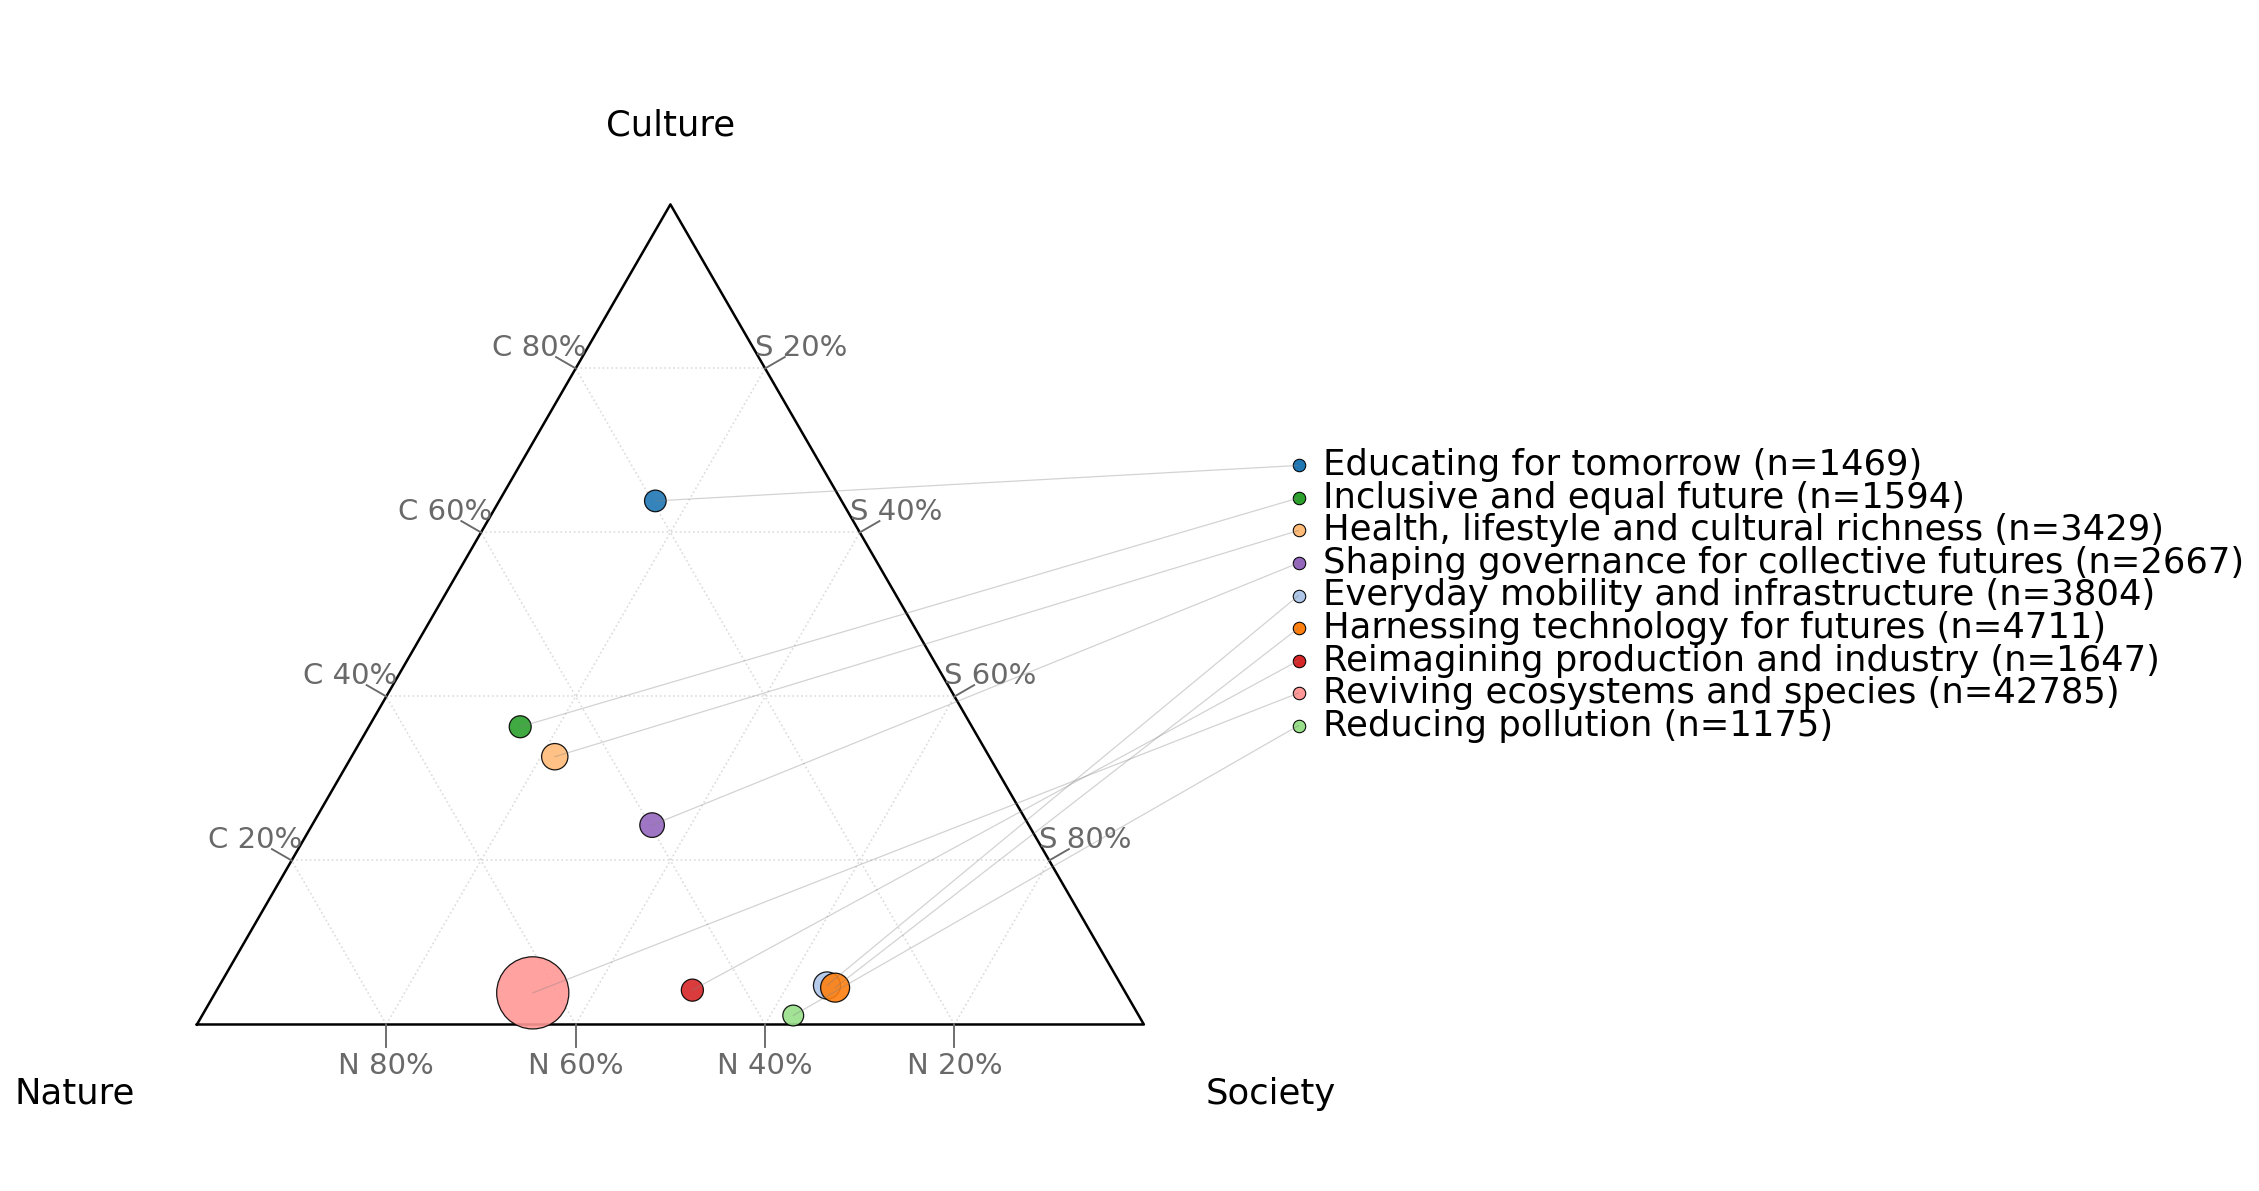

In [4]:
# -*- coding: utf-8 -*-
"""
The code to produce the figure of mapping meta-categories onto NFF triangle
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# --------------------- INPUTS ---------------------
fp = "/projappl/project_2004147/visions/bertopic_with_zeroshot_v9/df_geo_recoded_with_norm_zeroshot_with_meta2_anon.csv"
usecols = ["Meta_Category", "z_culture", "z_nature", "z_society"]

# Legend packing in legend-axis coordinates (smaller → tighter)
LEG_ROW_SPACING = 0.028   # try 0.022 for ultra-tight; stays tight at 14×7.6 too
GRID_LEVELS     = [0.2, 0.4, 0.6, 0.8]
LEGEND_TOP_K    = None    # keep all

# --------------------- LOAD & NORMALISE ---------------------
df = pd.read_csv(fp, usecols=usecols).dropna()
Z  = df[["z_culture","z_nature","z_society"]].astype(float)
rs = Z.sum(axis=1)
df = df.loc[rs > 0].copy()
Z  = Z.loc[rs > 0]; rs = rs.loc[rs > 0]
df["z_culture_norm"] = Z["z_culture"]/rs
df["z_nature_norm"]  = Z["z_nature"]/rs
df["z_society_norm"] = Z["z_society"]/rs

# --------------------- AGGREGATE (medians + counts) ---------------------
agg = (df.groupby("Meta_Category", as_index=False)
         .agg(count=("Meta_Category","size"),
              culture=("z_culture_norm","median"),
              nature =("z_nature_norm","median"),
              society=("z_society_norm","median")))
xyz = agg[["culture","nature","society"]].to_numpy()
xyz = (xyz.T / xyz.sum(axis=1)).T
agg["culture"], agg["nature"], agg["society"] = xyz[:,0], xyz[:,1], xyz[:,2]
if LEGEND_TOP_K and LEGEND_TOP_K < len(agg):
    agg = agg.sort_values("count", ascending=False).head(LEGEND_TOP_K).copy()

# --------------------- BARYCENTRIC → CARTESIAN ---------------------
H = np.sqrt(3)/2.0
V_TOP   = np.array([0.5, H])   # Culture (top)
V_LEFT  = np.array([0.0, 0.0]) # Nature (bottom-left)
V_RIGHT = np.array([1.0, 0.0]) # Society (bottom-right)

def bary_to_xy(c,n,s):  # c+n+s=1
    return (c*V_TOP) + (n*V_LEFT) + (s*V_RIGHT)

pts = np.vstack([bary_to_xy(c,n,s) for c,n,s in agg[["culture","nature","society"]].to_numpy()])
agg["x"], agg["y"] = pts[:,0], pts[:,1]

# --------------------- SIZES & COLOURS ---------------------
cmin, cmax = int(agg["count"].min()), int(agg["count"].max())
s_min, s_max = 100.0, 1200.0
sizes = np.full(len(agg),(s_min+s_max)/2.0) if cmax==cmin else s_min+(agg["count"]-cmin)*(s_max-s_min)/(cmax-cmin)
tab20 = plt.get_cmap("tab20").colors
colors = [tab20[i % len(tab20)] for i in range(len(agg))]
color_map = dict(zip(agg["Meta_Category"], colors))

# --------------------- FIGURE ---------------------
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"]  = 42
plt.rcParams["figure.dpi"]   = 150
# also align base font size to ~10 pt
plt.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(18, 9))   
ax  = fig.add_axes([0.06, 0.08, 0.64, 0.86])   # main triangle
lax = fig.add_axes([0.6, 0.08, 0.23, 0.86])    # callout legend

ax.set_aspect("equal"); ax.set_facecolor("white")
ax.set_xlim(-0.16, 1.16); ax.set_ylim(-0.16, H + 0.20)

# Triangle boundary
triangle = np.array([V_LEFT, V_RIGHT, V_TOP, V_LEFT])
ax.plot(triangle[:,0], triangle[:,1], color="black", linewidth=1.2, zorder=2)

# --------------------- INTERNAL GRID ---------------------
grid_kw = dict(color="lightgrey", linewidth=0.8, linestyle=":", alpha=0.8, zorder=0)
def draw_const_C(c): p1=bary_to_xy(c,1-c,0); p2=bary_to_xy(c,0,1-c); ax.plot([p1[0],p2[0]],[p1[1],p2[1]], **grid_kw)
def draw_const_N(n): p1=bary_to_xy(0,n,1-n); p2=bary_to_xy(1-n,n,0); ax.plot([p1[0],p2[0]],[p1[1],p2[1]], **grid_kw)
def draw_const_S(s): p1=bary_to_xy(0,1-s,s); p2=bary_to_xy(1-s,0,s); ax.plot([p1[0],p2[0]],[p1[1],p2[1]], **grid_kw)
for v in GRID_LEVELS: draw_const_C(v); draw_const_N(v); draw_const_S(v)

# --------------------- EXTERNAL TICKS (10 pt text) ---------------------
levels   = [0.2, 0.4, 0.6, 0.8]
tick_len = 0.024
lab_off  = 0.020   # ↑ increased distance of tick labels from the axis (was 0.010)
fs_ticks = 14
col_ticks = "dimgray"
centroid = (V_TOP+V_LEFT+V_RIGHT)/3
def outward_from_edge(P0,P1):
    mid=(P0+P1)/2; interior=centroid-mid; v=P1-P0
    n1=np.array([ v[1],-v[0]]); n2=-n1
    n = n1 if np.dot(n1, interior) < 0 else n2
    return n/np.linalg.norm(n)
def edge_ticks(P0,P1,prefix,value_fn=lambda t:t, zline=3, ztext=3):
    out = outward_from_edge(P0,P1)
    for t in levels:
        p=(1-t)*P0 + t*P1; p2=p + out*tick_len
        ax.plot([p[0],p2[0]],[p[1],p2[1]], color=col_ticks, linewidth=0.9, zorder=zline)
        pct=int(round(100*value_fn(t)))
        ax.text(p2[0]+out[0]*lab_off, p2[1]+out[1]*lab_off,
                f"{prefix} {pct}%", ha="center", va="center",
                fontsize=fs_ticks, color=col_ticks, zorder=ztext)

# Draw N and C ticks now…
edge_ticks(V_LEFT,  V_RIGHT, "N", value_fn=lambda t: 1-t, zline=3, ztext=4)  # base (reversed)
edge_ticks(V_LEFT,  V_TOP,   "C", value_fn=lambda t: t,   zline=3, ztext=4)  # left edge

# Corner labels
ax.text(V_TOP[0],   V_TOP[1]   + 0.065, "Culture", ha="center", va="bottom", fontsize=17, zorder=4)
ax.text(V_LEFT[0]  - 0.065, V_LEFT[1]  - 0.055, "Nature",  ha="right",  va="top", fontsize=17, zorder=4)
ax.text(V_RIGHT[0] + 0.065, V_RIGHT[1] - 0.055, "Society", ha="left",   va="top", fontsize=17, zorder=4)

# Bubbles
ax.scatter(agg["x"], agg["y"], s=sizes,
           c=[color_map[n] for n in agg["Meta_Category"]],
           edgecolors="black", linewidths=0.6, alpha=0.9, zorder=2)
ax.axis("off")

# --------------------- RIGHT-SIDE CALLOUT LEGEND (tight, 10 pt) ---------------------
leg = agg.sort_values(["y","x"], ascending=[False, True]).reset_index(drop=True)
lax.set_xlim(0,1); lax.set_ylim(0,1); lax.axis("off"); lax.set_facecolor("white")

names  = leg["Meta_Category"].astype(str).tolist()
counts = leg["count"].to_numpy()
n = len(names)
stack_h = LEG_ROW_SPACING*(n-1) if n>1 else 0.0
center_y = 0.50
top_y = min(0.98, center_y + stack_h/2.0)
ys = [top_y - i*LEG_ROW_SPACING for i in range(n)]

text_fs   = 17.0
bullet_ms = 6.0
text_x, bullet_x = 0.095, 0.055

legend_points = {}
for y,(nm,cnt) in zip(ys, zip(names,counts)):
    col = color_map[nm]
    lax.plot(bullet_x, y, marker='o', markersize=bullet_ms, color=col,
             markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
    lax.text(text_x, y, f"{nm} (n={cnt})", fontsize=text_fs, ha="left", va="center")
    legend_points[nm] = (bullet_x, y)

# --------------------- SUBTLE CONNECTORS (drawn BEFORE S ticks; low zorder) ---------------------
name_to_xy = {n:(x,y) for n,x,y in zip(agg["Meta_Category"], agg["x"], agg["y"])}
for nm in names:
    fig.add_artist(ConnectionPatch(
        xyA=legend_points[nm], coordsA="data", axesA=lax,
        xyB=name_to_xy[nm],    coordsB="data", axesB=ax,
        color="gray", lw=0.6, alpha=0.35, zorder=1.5  # ← subtle + behind labels
    ))

# --------------------- DRAW S TICKS LAST (on top of connectors) ---------------------
edge_ticks(V_TOP, V_RIGHT, "S", value_fn=lambda t: t, zline=5, ztext=10)  # right edge, topmost

# --------------------- SAVE ---------------------
out_pdf="meta_category_ternary_bubbles_GRID_LEGEND_TIGHT_FONTS10_fig14x7p6_connectors_subtle.pdf"
out_png="meta_category_ternary_bubbles_GRID_LEGEND_TIGHT_FONTS10_fig14x7p6_connectors_subtle.png"
fig.savefig(out_pdf, bbox_inches="tight")
fig.savefig(out_png, dpi=600, bbox_inches="tight")
print(os.path.abspath(out_pdf))
print(os.path.abspath(out_png))
plt.show()


In [5]:
# Code for box plot of "greenwashing probability" by Meta_Category
# Exports robust nonparametric stats (pairwise & one-vs-rest MWU with Holm correction) + normality checks.

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

# --------------------- CONFIG ---------------------
FP = "/projappl/project_2004147/visions/bertopic_with_zeroshot_v9/df_geo_recoded_with_norm_zeroshot_with_meta2_anon.csv"
META_COL = "Meta_Category"
METRIC_COL = "z_greenwashing"   # column holding "greenwashing probability"
AX_LABEL = "Greenwashing probability"

OUT_PDF  = "meta_category_prrliminary_greenwashing_boxplot.pdf"
PAIRWISE_CSV = "pairwise_mwu_holm.csv"
ONEVSREST_CSV = "one_vs_rest_mwu_holm.csv"
NORMALITY_CSV = "normality_tests.csv"

# --------------------- LOAD & CLEAN ---------------------
usecols = [META_COL, METRIC_COL]
df = pd.read_csv(FP, usecols=usecols)
df = df.dropna(subset=[META_COL, METRIC_COL]).copy()
df[META_COL] = df[META_COL].astype(str).str.strip()
df[METRIC_COL] = pd.to_numeric(df[METRIC_COL], errors="coerce")
df = df.dropna(subset=[METRIC_COL])

MIN_N = 10
grouped = {k: v[METRIC_COL].to_numpy() for k, v in df.groupby(META_COL)}
grouped = {k: x for k, x in grouped.items() if len(x) >= MIN_N}

if len(grouped) < 2:
    raise RuntimeError("Not enough categories with data to plot/analyze.")

# --------------------- ORDER BY MEDIAN ---------------------
medians = {k: float(np.nanmedian(x)) for k, x in grouped.items()}
order = [k for k, _ in sorted(medians.items(), key=lambda kv: kv[1])]  # ascending
data_ordered = [grouped[k] for k in order]

# --------------------- PLOT (BOX ONLY) ---------------------
# 18 cm width in inches
fig_w = 18.0 / 2.54
# height scaled by number of categories (kept compact but readable with fs=17)
fig_h = max(3.2, 0.42 * len(order))   # tweak factor as needed

plt.rcParams.update({
    "font.size": 17,
    "axes.titlesize": 17,
    "axes.labelsize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "savefig.dpi": 600,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
bp = ax.boxplot(
    data_ordered,
    vert=False,
    labels=order,
    patch_artist=True,
    showfliers=False,   # keep plot clean
    widths=0.7
)

# Styling
for box in bp['boxes']:
    box.set(facecolor="#d9d9d9", edgecolor="#333333", linewidth=1.0)
for med in bp['medians']:
    med.set(color="#000000", linewidth=1.2)
for whisk in bp['whiskers']:
    whisk.set(color="#333333", linewidth=1.0)
for cap in bp['caps']:
    cap.set(color="#333333", linewidth=1.0)

ax.set_xlabel(AX_LABEL)
ax.set_ylabel("")  # categories shown by labels already
ax.grid(axis="x", color="#e6e6e6", linestyle="--", linewidth=0.8, alpha=0.8)
ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig(OUT_PDF, bbox_inches="tight")
plt.close(fig)

# --------------------- STATS: OVERALL + NORMALITY ---------------------
# Overall Kruskal–Wallis (not plotted)
try:
    kw_H, kw_p = stats.kruskal(*data_ordered, nan_policy="omit")
except Exception:
    kw_H, kw_p = np.nan, np.nan

# Normality check per group (D’Agostino–Pearson) — for record, not for decision
norm_rows = []
for cat in order:
    x = grouped[cat]
    if len(x) >= 8:
        k2, p_norm = stats.normaltest(x, nan_policy="omit")
    else:
        k2, p_norm = np.nan, np.nan
    norm_rows.append({
        "category": cat,
        "n": int(len(x)),
        "median": float(np.nanmedian(x)),
        "mean": float(np.nanmean(x)),
        "std": float(np.nanstd(x, ddof=1)) if len(x) > 1 else np.nan,
        "normaltest_k2": k2,
        "normaltest_p": p_norm
    })
pd.DataFrame(norm_rows).to_csv(NORMALITY_CSV, index=False)

# --------------------- HELPERS: MWU + Holm + effect sizes ---------------------
def mwu_two_sided(x, y):
    # SciPy auto uses exact/normal as appropriate
    u_stat, p_val = stats.mannwhitneyu(x, y, alternative="two-sided", method="auto")
    n1, n2 = len(x), len(y)
    # Common language effect size (CLES) and Cliff's delta from U
    total_pairs = n1 * n2
    cles = np.nan if total_pairs == 0 else u_stat / total_pairs
    cliffs_delta = np.nan if total_pairs == 0 else (2.0 * cles) - 1.0
    return u_stat, p_val, cles, cliffs_delta

def holm_adjust(pvals):
    m = len(pvals)
    order_idx = np.argsort(pvals)
    adjusted = np.empty(m, dtype=float)
    prev = 0.0
    for rank, i in enumerate(order_idx):
        factor = m - rank
        adj = pvals[i] * factor
        adjusted[i] = adj
    # enforce monotonicity (Holm step-down)
    # recompute cumulative max on the sorted scale, then map back
    adj_sorted = adjusted[order_idx]
    adj_sorted = np.maximum.accumulate(adj_sorted)  # non-decreasing
    adjusted[order_idx] = adj_sorted
    return np.clip(adjusted, 0.0, 1.0)

# --------------------- PAIRWISE MWU (all-by-all) ---------------------
pairs = []
cats = order
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        c1, c2 = cats[i], cats[j]
        x, y = grouped[c1], grouped[c2]
        u, p, cles, cd = mwu_two_sided(x, y)
        pairs.append({
            "cat1": c1, "cat2": c2,
            "n1": len(x), "n2": len(y),
            "median1": float(np.nanmedian(x)),
            "median2": float(np.nanmedian(y)),
            "U": float(u), "p_raw": float(p),
            "CLES": float(cles) if cles is not None else np.nan,
            "cliffs_delta": float(cd) if cd is not None else np.nan,
            "direction": "cat1>cat2" if np.nanmedian(x) > np.nanmedian(y) else ("cat2>cat1" if np.nanmedian(y) > np.nanmedian(x) else "tie"),
        })

# Holm correction across all pairwise tests
if pairs:
    pvec = np.array([r["p_raw"] for r in pairs], dtype=float)
    p_holm = holm_adjust(pvec)
    for r, ph in zip(pairs, p_holm):
        r["p_holm"] = float(ph)
        r["significant_holm_0.05"] = bool(ph < 0.05)

pd.DataFrame(pairs).to_csv(PAIRWISE_CSV, index=False)

# --------------------- ONE-vs-REST MWU ---------------------
ovr_rows = []
all_values = df[METRIC_COL].to_numpy()
for cat in cats:
    x = grouped[cat]
    # Rest of data
    mask_rest = df[META_COL] != cat
    y = df.loc[mask_rest, METRIC_COL].to_numpy()
    u, p, cles, cd = mwu_two_sided(x, y)
    ovr_rows.append({
        "category": cat,
        "n_cat": len(x),
        "n_rest": len(y),
        "median_cat": float(np.nanmedian(x)),
        "median_rest": float(np.nanmedian(y)),
        "U": float(u),
        "p_raw": float(p),
        "CLES": float(cles) if cles is not None else np.nan,
        "cliffs_delta": float(cd) if cd is not None else np.nan,
        "direction": "higher_than_rest" if np.nanmedian(x) > np.nanmedian(y) else ("lower_than_rest" if np.nanmedian(x) < np.nanmedian(y) else "tie"),
    })

# Holm across 1-vs-rest family
if ovr_rows:
    pvec = np.array([r["p_raw"] for r in ovr_rows], dtype=float)
    p_holm = holm_adjust(pvec)
    for r, ph in zip(ovr_rows, p_holm):
        r["p_holm"] = float(ph)
        r["significant_holm_0.05"] = bool(ph < 0.05)

pd.DataFrame(ovr_rows).to_csv(ONEVSREST_CSV, index=False)

# --------------------- REPORT ---------------------
print(f"Saved box plot: {os.path.abspath(OUT_PDF)}")
print(f"Pairwise MWU (Holm) → {os.path.abspath(PAIRWISE_CSV)}")
print(f"One-vs-rest MWU (Holm) → {os.path.abspath(ONEVSREST_CSV)}")
print(f"Normality tests → {os.path.abspath(NORMALITY_CSV)}")
print(f"Kruskal–Wallis (overall): H={kw_H:.2f}, p={kw_p:.2e}")


/tmp/karasovo/29841775/ipykernel_295383/3778242092.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


Saved box plot: /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/meta_category_prrliminary_greenwashing_boxplot.pdf
Pairwise MWU (Holm) → /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/pairwise_mwu_holm.csv
One-vs-rest MWU (Holm) → /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/one_vs_rest_mwu_holm.csv
Normality tests → /projappl/project_2004147/visions/bertopic_with_zeroshot_v9/normality_tests.csv
Kruskal–Wallis (overall): H=1068.79, p=2.10e-225


In [6]:
# Code to produce a final greenwashing potential boxplot figure

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for better aesthetics

# General parameters
plt.rcParams.update({
    'font.family': 'serif',            # Set font family (e.g., 'serif', 'sans-serif')
    'figure.dpi': 600,                 # Set figure resolution
})

# Apply a professional-looking theme from seaborn
# MODIFIED THIS LINE: Added 'font_scale' to control text size globally.
sns.set_theme(style="ticks", palette="viridis", font_scale=0.7)

# --- Load data ---
fp = "/projappl/project_2004147/visions/bertopic_with_zeroshot_v9/df_geo_recoded_with_norm_zeroshot_with_meta2_anon.csv"
usecols = ["Meta_Category", "z_greenwashing"]
df = pd.read_csv(fp, usecols=usecols)

# --- Clean ---
df = df.dropna(subset=["Meta_Category", "z_greenwashing"]).copy()
df["Meta_Category"] = df["Meta_Category"].astype(str).str.strip()
df["z_greenwashing"] = pd.to_numeric(df["z_greenwashing"], errors="coerce")
df = df.dropna(subset=["z_greenwashing"])

# --- Order categories by median (ascending) ---
order = (
    df.groupby("Meta_Category")["z_greenwashing"]
      .median()
      .sort_values(ascending=True)
      .index.tolist()
)

# --- Prepare data in ordered list ---
data_ordered = [df.loc[df["Meta_Category"] == cat, "z_greenwashing"].values for cat in order]

# === BOX PLOT ===
# Convert 18 cm to inches for figsize (1 inch = 2.54 cm)
fig_width_cm = 18
fig_width_in = fig_width_cm / 2.54

# Using the object-oriented approach (fig, ax) gives more control
fig, ax = plt.subplots(figsize=(fig_width_in, len(order) * 0.25))

# Define properties for the box plot elements for a custom look
boxprops = {'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.7}
medianprops = {'color': 'black', 'linewidth': 1.5}

bp = ax.boxplot(
    data_ordered,
    vert=False,
    labels=order,
    patch_artist=True,    # Must be True to fill with color
    showfliers=False,     # Remove outliers
    boxprops=boxprops,
    medianprops=medianprops
)

# --- Further customizations for a better Look ---

# Set x-axis label
ax.set_xlabel("Predicted greenwashing potential")

# Add a light horizontal grid for better readability
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# Remove the top and right spines for a cleaner look (a "Tufte" principle)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ensure the layout is tight and no labels are cut off
fig.tight_layout()

# Save the figure in high quality
plt.savefig("meta_category_greenwashing_boxplot_publication.pdf", dpi=600)
plt.close()

/tmp/karasovo/29841775/ipykernel_295383/4231351805.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
